In [ ]:
import os
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import gc

In [ ]:
class SiameseMobileNet:
  def __init__(self, input_shape = (128, 128, 3)):
    self.input_shape = input_shape
    self.model = None
    self.history = None
    self._is_compiled = False

  def create_base_network(self):
    base_model = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = self.input_shape)

    for layer in base_model.layers[:-4]:
      layer.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        # layers.BatchNormalization(),
        layers.Dense(512, activation = 'relu'),
        # layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation = 'relu'),
        # layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation = 'relu'),
        # layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis = 1))
    ])

    return model

  def build_siamese_network(self):
    base_network = self.create_base_network()

    input_a = layers.Input(shape = self.input_shape)
    input_b = layers.Input(shape = self.input_shape)

    encoded_a = base_network(input_a)
    encoded_b = base_network(input_b)

    l1_distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_a, encoded_b])
    # l2_distance = layers.Lambda(lambda x: tf.square(x[0] - x[1]))([encoded_a, encoded_b])
    # cosine_distance = layers.Lambda(lambda x: x[0] * x[1])([encoded_a, encoded_b])

    # merged_distances = layers.Concatenate()([l1_distance, l2_distance, cosine_distance])

    prediction = layers.Dense(64, activation = 'relu')(l1_distance)
    # prediction = layers.BatchNormalization()(prediction)
    prediction = layers.Dropout(0.3)(prediction)
    prediction = layers.Dense(32, activation = 'relu')(prediction)
    # prediction = layers.BatchNormalization()(prediction)
    # prediction = layers.Dropout(0.3)(prediction)
    # prediction = layers.Dense(32, activation = 'relu')(prediction)
    prediction = layers.Dense(1, activation = 'sigmoid')(prediction)

    self.model = Model(inputs = [input_a, input_b], outputs = prediction)

  def load_and_preprocess_data(self, data_path):
    wanted_path = os.path.join(data_path, 'wanted')
    unwanted_path = os.path.join(data_path, 'unwanted')

    wanted_images = {}
    unwanted_images = {}

    for person_folder in os.listdir(wanted_path):
      person_path = os.path.join(wanted_path, person_folder)
      if os.path.isdir(person_path):
        images = []
        for img_file in os.listdir(person_path):
          if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif')):
            img_path = os.path.join(person_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              img = cv2.resize(img, self.input_shape[:2])
              img = img.astype('float32') / 255.0
              images.append(img)
        wanted_images[person_folder] = images

    for person_folder in os.listdir(unwanted_path):
      person_path = os.path.join(unwanted_path, person_folder)
      if os.path.isdir(person_path):
        images = []
        for img_file in os.listdir(person_path):
          if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif')):
            img_path = os.path.join(person_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              img = cv2.resize(img, self.input_shape[:2])
              img = img.astype('float32') / 255.0
              images.append(img)
        unwanted_images[person_folder] = images

    return wanted_images, unwanted_images

  def create_pairs_enhanced(self, wanted_images, unwanted_images, augmentation_factor = 2, negative_multiplier = 3):
    pairs_a = []
    pairs_b = []
    labels = []

    positive_count = 0

    for person_id, images in wanted_images.items():
      if len(images) >= 2:
        for i in range(len(images)):
          for j in range(i + 1, len(images)):
            pairs_a.append(images[i])
            pairs_b.append(images[j])
            labels.append(1)
            positive_count += 1

    for person_id, images in unwanted_images.items():
      if len(images) >= 2:
        for i in range(len(images)):
          for j in range(i + 1, len(images)):
            pairs_a.append(images[i])
            pairs_b.append(images[j])
            labels.append(1)
            positive_count += 1

    print(f"Positive pairs created: {positive_count}")

    if augmentation_factor > 1:
      print(f"Augmenting positive pairs with factor {augmentation_factor}")
      datagen = ImageDataGenerator(
          rotation_range = 15,
          width_shift_range = 0.15,
          height_shift_range = 0.15,
          horizontal_flip = True,
          zoom_range = 0.15,
          brightness_range = [0.8, 1.2],
          fill_mode = 'nearest'
      )

      original_positive_pairs = positive_count
      for aug_iter in range(augmentation_factor - 1):
        print(f"Augmentation iteration {aug_iter + 1}/{augmentation_factor - 1}")
        for i in range(original_positive_pairs):
          img_a = pairs_a[i].reshape((1,) + pairs_a[i].shape)
          img_b = pairs_b[i].reshape((1,) + pairs_b[i].shape)

          aug_a = next(datagen.flow(img_a, batch_size = 1))[0]
          aug_b = next(datagen.flow(img_b, batch_size = 1))[0]

          pairs_a.append(aug_a)
          pairs_b.append(aug_b)
          labels.append(1)

      print(f"Total positive pairs after augmentation: {len([l for l in labels if l == 1])}")

      all_wanted_with_ids = []
      all_unwanted_with_ids = []

      for person_id, images in wanted_images.items():
        for img in images:
          all_wanted_with_ids.append((person_id, img))

      for person_id, images in unwanted_images.items():
        for img in images:
          all_unwanted_with_ids.append((person_id, img))

      # calculate current positive count (after augmentation)
      current_positive_count = len([l for l in labels if l == 1])
      num_negative_target = current_positive_count * negative_multiplier
      negative_count = 0

      # different: wanted vs unwanted
      cross_category_pairs = min(num_negative_target // 3,
                                 len(all_wanted_with_ids) * len(all_unwanted_with_ids))
      for _ in range(cross_category_pairs):
        person1_id, img1 = random.choice(all_wanted_with_ids)
        person2_id, img2 = random.choice(all_unwanted_with_ids)
        pairs_a.append(img1)
        pairs_b.append(img2)
        labels.append(0)
        negative_count += 1

      # different: wanted vs wanted
      wanted_persons = list(wanted_images.keys())
      if len(wanted_persons) > 2:
        max_wanted_pairs = sum([len(wanted_images[p1]) * len(wanted_images[p2])
        for p1, p2 in itertools.combinations(wanted_persons, 2)])
        wanted_negative_pairs = min(num_negative_target // 3, max_wanted_pairs)

        for _ in range(wanted_negative_pairs):
          person1, person2 = random.sample(wanted_persons, 2)
          if wanted_images[person1] and wanted_images[person2]:
            img1 = random.choice(wanted_images[person1])
            img2 = random.choice(wanted_images[person2])
            pairs_a.append(img1)
            pairs_b.append(img2)
            labels.append(0)
            negative_count += 1

      # different: unwanted vs unwanted
      unwanted_persons = list(unwanted_images.keys())
      if len(unwanted_persons) >= 2:
            max_unwanted_pairs = sum([len(unwanted_images[p1]) * len(unwanted_images[p2])
                                      for p1, p2 in itertools.combinations(unwanted_persons, 2)])
            unwanted_negative_pairs = min(num_negative_target // 3, max_unwanted_pairs)

            print(f"  Creating {unwanted_negative_pairs} unwanted vs unwanted pairs...")
            for _ in range(unwanted_negative_pairs):
                person1, person2 = random.sample(unwanted_persons, 2)
                if unwanted_images[person1] and unwanted_images[person2]:
                    img1 = random.choice(unwanted_images[person1])
                    img2 = random.choice(unwanted_images[person2])
                    pairs_a.append(img1)
                    pairs_b.append(img2)
                    labels.append(0)
                    negative_count += 1

    print(f"Negative pairs created: {negative_count}")
    print(f"Total pairs: {len(labels)}")
    print(f"Positive/Negative ratio: {current_positive_count}/{negative_count} = {current_positive_count/negative_count:.2f}")

    return np.array(pairs_a), np.array(pairs_b), np.array(labels)

  def train(self, data_path, epochs = 20, batch_size = 32, use_enhanced_pairs = True, augmentation_factor = 2, negative_multiplier = 3):
    wanted_images, unwanted_images = self.load_and_preprocess_data(data_path)

    if use_enhanced_pairs:
      pairs_a, pairs_b, labels = self.create_pairs_enhanced(
          wanted_images, unwanted_images,
          augmentation_factor = augmentation_factor,
          negative_multiplier = negative_multiplier
      )
    else:
      pass

    X_train_a, X_val_a, X_train_b, X_val_b, y_train, y_val = train_test_split(
        pairs_a, pairs_b, labels,
        test_size = 0.2,
        random_state = 42,
        stratify = labels
    )

    print(f"\nTraining set: {len(y_train)} pairs")
    print(f"Validation set: {len(y_val)} pairs")

    if self.model is None:
      self.build_siamese_network()

    if not self._is_compiled:
      print("Model has not been compiled. Compiling now...")

      initial_lr = 0.001
      # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      #     initial_learning_rate = initial_lr,
      #     decay_steps = 100,
      #     decay_rate = 0.9,
      #     staircase = True
      # )

      self.model.compile(
          optimizer = optimizers.Adam(learning_rate = initial_lr),
          loss = 'binary_crossentropy',
          metrics = ['accuracy']
      )
      self._is_compiled = True
    else:
      print("Model is already compiled. Skipping compilation")

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_accuracy',
            patience = 15,
            mode = 'max',
            restore_best_weights = True,
            verbose = 1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 20,
            mode = 'min',
            restore_best_weights = False,
            verbose = 1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            factor = 0.5,
            patience = 5,
            min_lr = 1e-7,
            verbose = 1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_siamese_mobilenet_lightweight.h5',
            monitor = 'val_accuracy',
            save_best_only = True,
            mode = 'max',
            verbose = 1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir = './logs',
            histogram_freq = 1,
            write_graph = True
        )
    ]

    print("\n=== Starting training ===")
    self.history = self.model.fit(
        [X_train_a, X_train_b], y_train,
        validation_data = ([X_val_a, X_val_b], y_val),
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callbacks,
        verbose = 1
    )

    return X_val_a, X_val_b, y_val

  def fine_tune(self, data_path, epochs = 20, batch_size = 32, use_enhanced_pairs = True, augmentation_factor = 2, negative_multiplier = 3, fine_tune_lr = 1e-5):
    wanted_images, unwanted_images = self.load_and_preprocess_data(data_path)
    pairs_a, pairs_b, labels = self.create_pairs_enhanced(
        wanted_images, unwanted_images, augmentation_factor = augmentation_factor, negative_multiplier = negative_multiplier
    )

    X_train_a, X_val_a, X_train_b, X_val_b, y_train, y_val = train_test_split(
        pairs_a, pairs_b, labels,
        test_size = 0.2,
        random_state = 42,
        stratify = labels
    )
    self.model.compile(optimizers.Adam(learning_rate = fine_tune_lr),
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy'])
    self._is_compiled = True

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_accuracy',
            patience = 15,
            mode = 'max',
            restore_best_weights = True,
            verbose = 1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            factor = 0.5,
            patience = 5,
            min_lr = 1e-8,
            verbose = 1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_siamese_mobilenet_finetuned.h5',
            monitor = 'val_accuracy',
            save_best_only = True,
            mode = 'max',
            verbose = 1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir = './logs_finetune',
            histogram_freq = 1,
            write_graph = True
        )
    ]

    self.history = self.model.fit(
        [X_train_a, X_train_b], y_train,
        validation_data = ([X_val_a, X_val_b], y_val),
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callbacks,
        verbose = 1
    )
    return X_val_a, X_val_b, y_val

  def evaluate_model(self, X_val_a, X_val_b, y_val):
    y_pred_prob = self.model.predict([X_val_a, X_val_b])
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)

    print('*** Siamese Network (MobileNet based) results ***')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'AUC-ROC: {auc_roc:.4f}')

    self.plot_training_history()
    self.plot_confusion_matrix(y_val, y_pred)
    self.plot_roc_curve(y_val, y_pred_prob)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }

  def plot_training_history(self):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

    ax1.plot(self.history.history['accuracy'], label = 'Training Accuracy')
    ax1.plot(self.history.history['val_accuracy'], label = 'Validation Accuracy')
    ax1.set_title('Siamese Network - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(self.history.history['loss'], label = 'Training loss')
    ax2.plot(self.history.history['val_loss'], label = 'Validation loss')
    ax2.set_title('Siamese Network - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

  def plot_confusion_matrix(self, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
                xticklabels = ['Different Person', 'Same Person'],
                yticklabels = ['Different Person', 'Same Person'])
    plt.title('Siamese Network - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

  def plot_roc_curve(self, y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc_score = roc_auc_score(y_true, y_pred_prob)

    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2,
             label = f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Siamese Network - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

  def create_test_pairs(self, wanted_images, unwanted_images):
    pairs_a = []
    pairs_b = []
    labels = []

    positive_count = 0

    # wanted positive pairs
    for person_id, images in wanted_images.items():
      if len(images) >= 2:
        # generate all possible combinations
        for i, j in itertools.combinations(range(len(images)), 2):
          pairs_a.append(images[i])
          pairs_b.append(images[j])
          labels.append(1)
          positive_count += 1
        print(f"Wanted person {person_id}: {len(images)} images -> {len(list(itertools.combinations(range(len(images)), 2)))} pairs")

    # unwanted positive pairs
    for person_id, images in unwanted_images.items():
      if len(images) >= 2:
        for i, j in itertools.combinations(range(len(images)), 2):
          pairs_a.append(images[i])
          pairs_b.append(images[j])
          labels.append(1)
          positive_count += 1
        print(f"Unwanted person {person_id}: {len(images)} images -> {len(list(itertools.combinations(range(len(images)), 2)))} pairs")
    print(f'Total positive pairs: {positive_count}')

    # negative pairs
    negative_count = 0

    # 1. wanted vs unwanted
    all_wanted_images = [(pid, img) for pid, imgs in wanted_images.items() for img in imgs]
    all_unwanted_images = [(pid, img) for pid, imgs in unwanted_images.items() for img in imgs]

    cross_category_count = 0
    for wanted_pid, wanted_img in all_wanted_images:
      for unwanted_pid, unwanted_img in all_unwanted_images:
        pairs_a.append(wanted_img)
        pairs_b.append(unwanted_img)
        labels.append(0)
        cross_category_count += 1
        negative_count += 1

    print(f"Cross-category (wanted vs unwanted): {cross_category_count} pairs")

    # 2. different wanted persons
    wanted_persons = list(wanted_images.keys())
    wanted_vs_wanted_count = 0

    if len(wanted_persons) >= 2:
      for person1, person2 in itertools.combinations(wanted_persons, 2):
        for img1 in wanted_images[person1]:
          for img2 in wanted_images[person2]:
            pairs_a.append(img1)
            pairs_b.append(img2)
            labels.append(0)
            wanted_vs_wanted_count += 1
            negative_count += 1

    print(f"Different wanted persons: {wanted_vs_wanted_count} pairs")

    # 3. different unwanted persons
    unwanted_persons = list(unwanted_images.keys())
    unwanted_vs_unwanted_count = 0

    if len(unwanted_persons) >= 2:
      for person1, person2 in itertools.combinations(unwanted_persons, 2):
        for img1 in unwanted_images[person1]:
          for img2 in unwanted_images[person2]:
            pairs_a.append(img1)
            pairs_b.append(img2)
            labels.append(0)
            unwanted_vs_unwanted_count += 1
            negative_count += 1

    print(f"Different unwanted persons: {unwanted_vs_unwanted_count} pairs")
    print(f"Total negative pairs: {negative_count}")

    return np.array(pairs_a), np.array(pairs_b), np.array(labels)

  def test_model(self, data_path):
    wanted_images, unwanted_images = self.load_and_preprocess_data(data_path)
    pairs_a, pairs_b, labels = self.create_test_pairs(wanted_images, unwanted_images)

    y_pred_prob = self.model.predict([pairs_a, pairs_b], batch_size = 32, verbose = 1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    accuracy = accuracy_score(labels, y_pred)

    print(f'\n*** Testing results ***')
    print(f'Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')

In [ ]:
siamese_mobilenet = SiameseMobileNet()

data_base_path = '/content/drive/MyDrive/ĐATN/data_base/train'
test_base_path = '/content/drive/MyDrive/ĐATN/data_base/test'

X_val_a, X_val_b, y_val = siamese_mobilenet.train(
    data_base_path,
    epochs = 20,
    batch_size = 32,
    use_enhanced_pairs = True,
    augmentation_factor = 2,
    negative_multiplier = 3
)

Positive pairs created: 449
Augmenting positive pairs with factor 2
Augmentation iteration 1/1
Total positive pairs after augmentation: 898
  Creating 260 unwanted vs unwanted pairs...
Negative pairs created: 2056
Total pairs: 2954
Positive/Negative ratio: 898/2056 = 0.44

Training set: 2363 pairs
Validation set: 591 pairs
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model has not been compiled. Compiling now...

=== Starting training ===
Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7574 - loss: 0.5242
Epoch 1: val_accuracy improved from -inf to 0.73435, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 69s 560ms/step - accuracy: 0.7582 - loss: 0.5233 - val_accuracy: 0.7343 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 2/20
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8441 - loss: 0.3796
Epoch 2: val_accuracy did not improve from 0.73435
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8442 - loss: 0.3794 - val_accuracy: 0.7343 - val_loss: 0.4311 - learning_rate: 0.0010
Epoch 3/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8480 - loss: 0.3783
Epoch 3: val_accuracy improved from 0.73435 to 0.73604, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.8480 - loss: 0.3782 - val_accuracy: 0.7360 - val_loss: 0.4106 - learning_rate: 0.0010
Epoch 4/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8445 - loss: 0.3535
Epoch 4: val_accuracy improved from 0.73604 to 0.83926, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8446 - loss: 0.3532 - val_accuracy: 0.8393 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 5/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8439 - loss: 0.3279
Epoch 5: val_accuracy improved from 0.83926 to 0.84095, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8441 - loss: 0.3277 - val_accuracy: 0.8409 - val_loss: 0.3712 - learning_rate: 0.0010
Epoch 6/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8457 - loss: 0.3220
Epoch 6: val_accuracy improved from 0.84095 to 0.84772, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8457 - loss: 0.3220 - val_accuracy: 0.8477 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8584 - loss: 0.2892
Epoch 7: val_accuracy improved from 0.84772 to 0.85618, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8585 - loss: 0.2892 - val_accuracy: 0.8562 - val_loss: 0.3288 - learning_rate: 0.0010
Epoch 8/20
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8661 - loss: 0.2725
Epoch 8: val_accuracy did not improve from 0.85618
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.8662 - loss: 0.2728 - val_accuracy: 0.8477 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 9/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8834 - loss: 0.2431
Epoch 9: val_accuracy improved from 0.85618 to 0.85956, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8832 - loss: 0.2436 - val_accuracy: 0.8596 - val_loss: 0.3047 - learning_rate: 0.0010
Epoch 10/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8718 - loss: 0.2584
Epoch 10: val_accuracy improved from 0.85956 to 0.86633, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8719 - loss: 0.2583 - val_accuracy: 0.8663 - val_loss: 0.3072 - learning_rate: 0.0010
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8938 - loss: 0.2340
Epoch 11: val_accuracy did not improve from 0.86633
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8937 - loss: 0.2341 - val_accuracy: 0.8646 - val_loss: 0.2948 - learning_rate: 0.0010
Epoch 12/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9049 - loss: 0.2209
Epoch 12: val_accuracy improved from 0.86633 to 0.87648, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9047 - loss: 0.2210 - val_accuracy: 0.8765 - val_loss: 0.2917 - learning_rate: 0.0010
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9054 - loss: 0.2049
Epoch 13: val_accuracy improved from 0.87648 to 0.89679, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9053 - loss: 0.2050 - val_accuracy: 0.8968 - val_loss: 0.2610 - learning_rate: 0.0010
Epoch 14/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9035 - loss: 0.2070
Epoch 14: val_accuracy improved from 0.89679 to 0.90186, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9035 - loss: 0.2070 - val_accuracy: 0.9019 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 15/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9060 - loss: 0.2059
Epoch 15: val_accuracy did not improve from 0.90186
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9060 - loss: 0.2060 - val_accuracy: 0.9002 - val_loss: 0.2408 - learning_rate: 0.0010
Epoch 16/20
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9157 - loss: 0.1831
Epoch 16: val_accuracy did not improve from 0.90186
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9154 - loss: 0.1837 - val_accuracy: 0.8917 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 17/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9277 - loss: 0.1700
Epoch 17: val_accuracy improved from 0.90186 to 0.90355, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9277 - loss: 0.1701 - val_accuracy: 0.9036 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 18/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9227 - loss: 0.1747
Epoch 18: val_accuracy improved from 0.90355 to 0.91032, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9227 - loss: 0.1747 - val_accuracy: 0.9103 - val_loss: 0.2777 - learning_rate: 0.0010
Epoch 19/20
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9354 - loss: 0.1509
Epoch 19: val_accuracy did not improve from 0.91032
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9352 - loss: 0.1516 - val_accuracy: 0.8968 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 20/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9381 - loss: 0.1526
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: val_accuracy improved from 0.91032 to 0.91371, saving model to best_siamese_mobilenet_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9378 - loss: 0.1528 - val_accuracy: 0.9137 - val_loss: 0.2752 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 20.


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 383ms/step
*** Siamese Network (MobileNet based) results ***
Accuracy: 0.9137
Precision: 0.9161
Recall: 0.7889
F1-Score: 0.8478
AUC-ROC: 0.9692


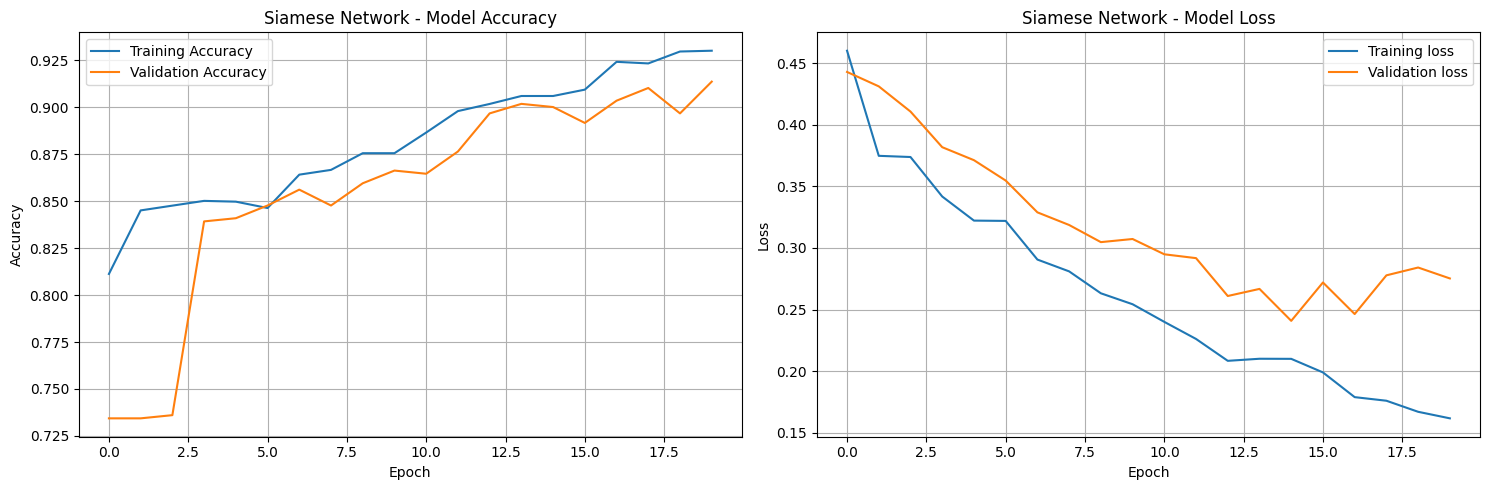

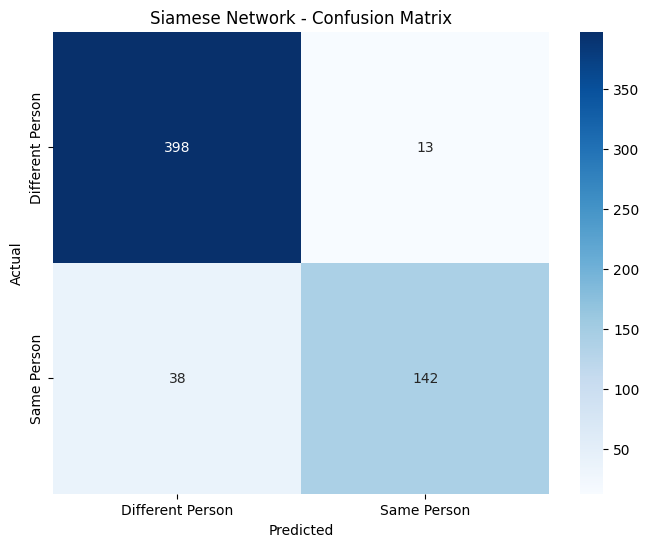

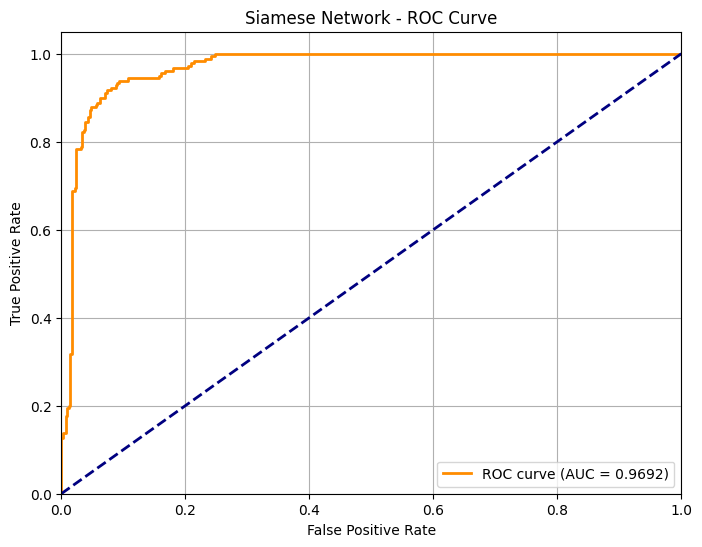

In [ ]:
results_base = siamese_mobilenet.evaluate_model(X_val_a, X_val_b, y_val)

In [ ]:
siamese_mobilenet.test_model(test_base_path)

Wanted person 27: 2 images -> 1 pairs
Wanted person 22: 2 images -> 1 pairs
Wanted person 21: 2 images -> 1 pairs
Wanted person 11: 2 images -> 1 pairs
Wanted person 06: 2 images -> 1 pairs
Wanted person 05: 2 images -> 1 pairs
Wanted person 01: 2 images -> 1 pairs
Wanted person 02: 2 images -> 1 pairs
Total positive pairs: 8
Cross-category (wanted vs unwanted): 138 pairs
Different wanted persons: 245 pairs
Different unwanted persons: 15 pairs
Total negative pairs: 398
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 995ms/step

*** Testing results ***
Accuracy: 0.9458 (94.58%)


In [ ]:
base_model_path = 'siamese_mobilenet_base_lightweight.h5'
siamese_mobilenet.model.save(base_model_path)

In [ ]:
import gc

data_novel_path = '/content/drive/MyDrive/ĐATN/data_novel/train'
test_novel_path = '/content/drive/MyDrive/ĐATN/data_novel/test'

# del siamese_vgg16
tf.keras.backend.clear_session()
gc.collect()

X_val_a_novel, X_val_b_novel, y_val_novel = siamese_mobilenet.fine_tune(
    data_novel_path,
    epochs = 20,
    batch_size = 32,
    use_enhanced_pairs = True,
    augmentation_factor = 2,
    negative_multiplier = 3,
    fine_tune_lr = 1e-5
)

Positive pairs created: 63
Augmenting positive pairs with factor 2
Augmentation iteration 1/1
Total positive pairs after augmentation: 126
  Creating 126 unwanted vs unwanted pairs...
Negative pairs created: 378
Total pairs: 504
Positive/Negative ratio: 126/378 = 0.33
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7849 - loss: 0.5218  
Epoch 1: val_accuracy improved from -inf to 0.86139, saving model to best_siamese_mobilenet_finetuned.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7849 - loss: 0.5198 - val_accuracy: 0.8614 - val_loss: 0.4929 - learning_rate: 1.0000e-05
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7867 - loss: 0.4872
Epoch 2: val_accuracy did not improve from 0.86139
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.7858 - loss: 0.4858 - val_accuracy: 0.8614 - val_loss: 0.4928 - learning_rate: 1.0000e-05
Epoch 3/20
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7716 - loss: 0.4444
Epoch 3: val_accuracy did not improve from 0.86139
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.7665 - loss: 0.4543 - val_accuracy: 0.8614 - val_loss: 0.4930 - learning_rate: 1.0000e-05
Epoch 4/20
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7813 - loss: 0.4710
Epoch 4: val_accuracy did not improve from 0.86139
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.7837 - loss: 0.4743 - val_accuracy: 0.8614 - val_loss: 0.4920 - learning_rate: 1.0000e-05
Epoch 5/20
12/

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.7804 - loss: 0.5500 - val_accuracy: 0.8713 - val_loss: 0.4900 - learning_rate: 1.0000e-05
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7765 - loss: 0.4994
Epoch 11: val_accuracy did not improve from 0.87129
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.7780 - loss: 0.4969 - val_accuracy: 0.8713 - val_loss: 0.4889 - learning_rate: 1.0000e-05
Epoch 12/20
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7776 - loss: 0.5697
Epoch 12: val_accuracy did not improve from 0.87129
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.7774 - loss: 0.5594 - val_accuracy: 0.8713 - val_loss: 0.4893 - learning_rate: 1.0000e-05
Epoch 13/20
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7655 - loss: 0.4513
Epoch 13: val_accuracy did not improve from 0.87129
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.7657 - loss: 0.4555 - val_accuracy: 0.8713 - val_loss: 0.4890 - learning_rate: 1.0000e-05
Epoch 

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
*** Siamese Network (MobileNet based) results ***
Accuracy: 0.8713
Precision: 0.8750
Recall: 0.5600
F1-Score: 0.6829
AUC-ROC: 0.8242


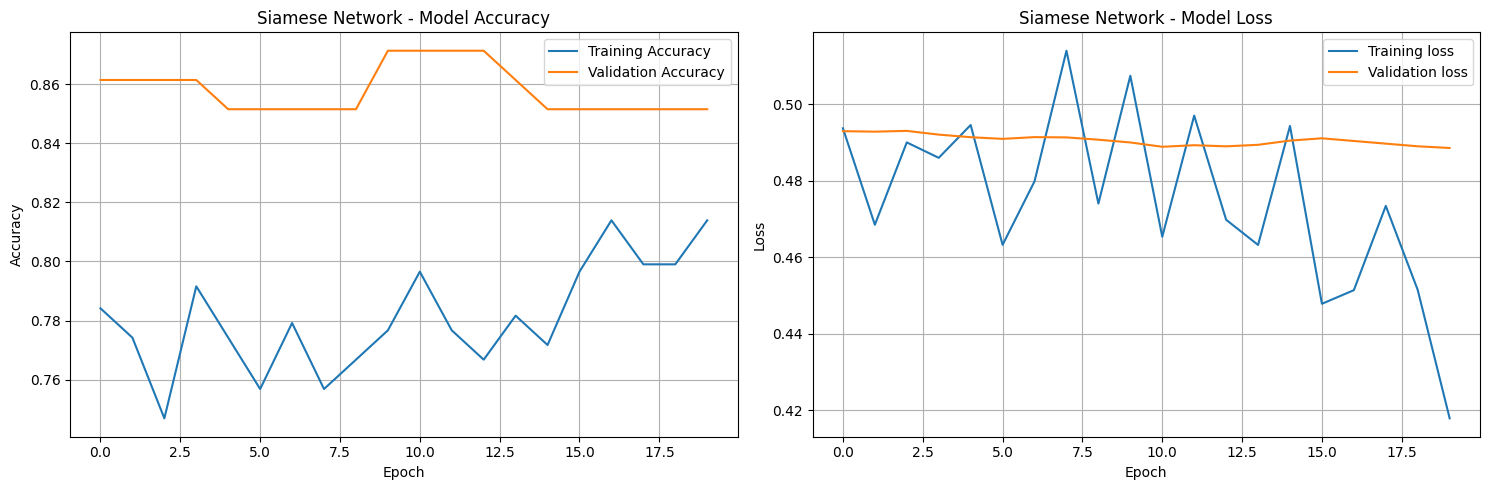

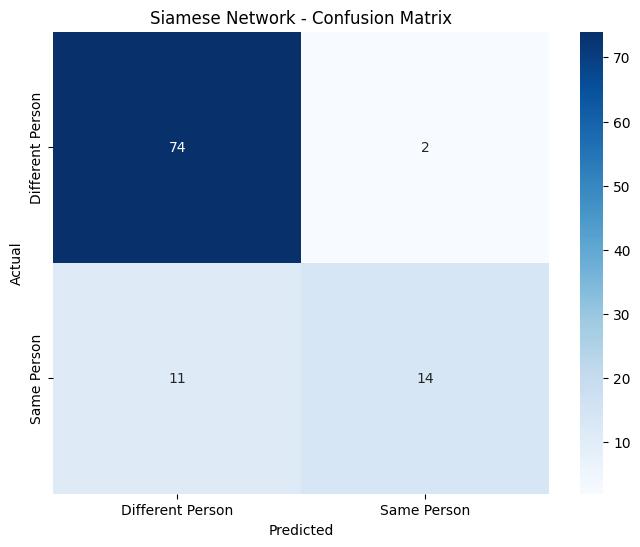

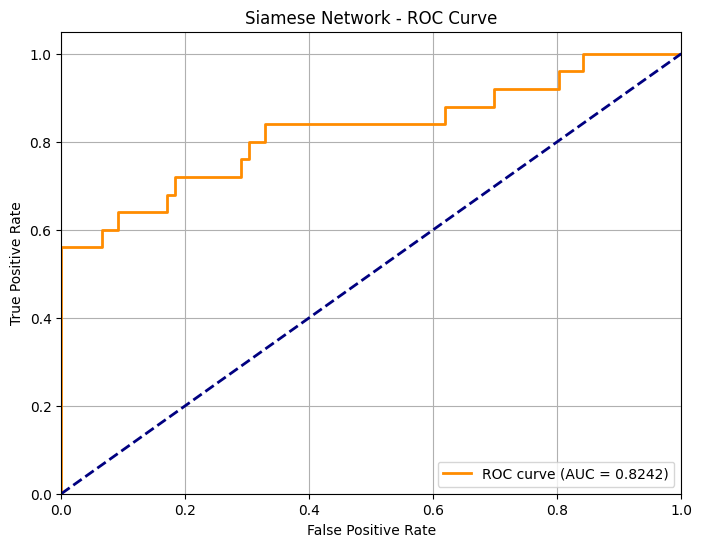

In [ ]:
results_novel = siamese_mobilenet.evaluate_model(X_val_a_novel, X_val_b_novel, y_val_novel)

In [ ]:
siamese_mobilenet.test_model(test_novel_path)

Wanted person 28: 3 images -> 3 pairs
Wanted person 26: 5 images -> 10 pairs
Wanted person 30: 5 images -> 10 pairs
Wanted person 23: 7 images -> 21 pairs
Wanted person 24: 6 images -> 15 pairs
Wanted person 25: 4 images -> 6 pairs
Wanted person 18: 4 images -> 6 pairs
Wanted person 15: 2 images -> 1 pairs
Wanted person 13: 4 images -> 6 pairs
Wanted person 16: 4 images -> 6 pairs
Wanted person 14: 4 images -> 6 pairs
Wanted person 12: 4 images -> 6 pairs
Wanted person 17: 2 images -> 1 pairs
Wanted person 07: 3 images -> 3 pairs
Wanted person 08: 4 images -> 6 pairs
Unwanted person 10: 2 images -> 1 pairs
Unwanted person 11: 2 images -> 1 pairs
Total positive pairs: 108
Cross-category (wanted vs unwanted): 488 pairs
Different wanted persons: 1724 pairs
Different unwanted persons: 26 pairs
Total negative pairs: 2238
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step

*** Testing results ***
Accuracy: 0.8986 (89.86%)


In [ ]:
final_model_path = 'siamese_mobilenet_novel.h5'
siamese_mobilenet.model.save(final_model_path)